In [1]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "3" # pick gpu

In [1]:

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
#import stuff from library
from functions.fno_wrapper import FNO1dWrapper as FNO1d
from neuralop import Trainer
from neuralop import LpLoss, H1Loss
from neuralop.training import BasicLoggerCallback

In [ ]:
from functions.functions import *

In [4]:
# Define parameters
N = 4  # Number of particles
num_states = 5000  # Number of input states
train_ratio = 0.8  # Ratio of training to testing data
batch_size=32
modes= (2**N)//2 #+1
hidden_channels=64
proj_lift_channel= 128
epochs=100
lr=1e-2

In [8]:
energy_grid = torch.linspace(0, 1, 4).unsqueeze(0).expand(3, -1)
print(energy_grid.unsqueeze(1))

tensor([[[0.0000, 0.3333, 0.6667, 1.0000]],

        [[0.0000, 0.3333, 0.6667, 1.0000]],

        [[0.0000, 0.3333, 0.6667, 1.0000]]])


In [ ]:
from functions.seed_utilis import *

seed=2
set_seed(seed) 

In [7]:
J_min = -2  # min value for J
J_max = 2   # max value for J
Jx = np.random.uniform(J_min, J_max)
Jy = np.random.uniform(J_min, J_max)
Jz = np.random.uniform(J_min, J_max)
h= np.random.uniform(J_min, J_max)
print(Jx,Jy,Jz,h)

-0.25602039143198496 -1.8962950726884347 0.19864991151483657 -0.2587104295268925


In [8]:
train_loader,test_loader=create_dataset(N,num_states,train_ratio,batch_size,Jx=Jx,Jy=Jy,Jz=Jz,h=h)

[Dataset] x_train: torch.Size([4000, 2, 16]), y_train: torch.Size([4000, 1, 16])
[Dataset] x_test: torch.Size([1000, 2, 16]), y_test: torch.Size([1000, 1, 16])


In [ ]:
model = FNO1d(n_modes_height=modes,
        hidden_channels=hidden_channels,
        in_channels=2,
        out_channels=1,
        complex=True,
        projection_channels=proj_lift_channel,
        lifting_channels=proj_lift_channel,
        arch_no=1,)
model = model.to('cuda')

In [10]:
#optimizer = torch.optim.Adam(model.parameters(),lr=5e-3,weight_decay=1e-4)

optimizer = torch.optim.AdamW(model.parameters(),lr=lr,weight_decay=1e-4) 
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)

In [11]:
#l2loss = LpLoss(d=2, p=2)
#h1loss = H1Loss(d=2)

#train_loss = h1loss
#eval_losses={'h1': h1loss, 'l2': l2loss}

l2loss = LpLoss(d=1, reduce_dims=[0, 1], p=2, reductions=['sum','mean'])
h1loss = H1Loss(d=1, reduce_dims=[0, 1],reductions=['sum','mean'])

def mse_loss(y_pred, y, **kwargs):
    assert y_pred.shape == y.shape
    assert y_pred.ndim == 3
    diff = (y_pred - y) 
    loss = (diff * diff.conj()).mean(dim=-1).sum(dim=[0])
    return loss.real

train_loss = mse_loss # h1loss
eval_losses={'h1': h1loss, 'l2': l2loss} # adding fidelity 

In [12]:
import wandb
    
config = { 
    "No_of_particles": N,
    "batch_size": batch_size,
    "n_train": num_states * train_ratio,
    "n_test": num_states * (1 - train_ratio),
    "learning_rate": lr,
    "hidden_channel": hidden_channels,
    "proj/lift": proj_lift_channel,
    "epochs": epochs,
}


project="fno_arch_1"
name="fno_random"
entity= "fs1132429_" # put your username here


wandb_init_args = dict(
        config=config,
        project=project,
        name=name,
        entity=entity,
    )

In [13]:



device='cuda'


callbacks = [
    BasicLoggerCallback(wandb_init_args)
]
trainer = Trainer(model=model, n_epochs=epochs,
    device=device,
    callbacks=callbacks,
    data_processor=None,
    wandb_log=True,
    log_test_interval=1, # log at every epoch
    use_distributed=False,
    verbose=True)

print(trainer)
trainer.train(train_loader=train_loader,
    test_loaders={"test_loader": test_loader},
    optimizer=optimizer,
    scheduler=scheduler,
    regularizer=False,
    training_loss=train_loss,
    eval_losses=eval_losses,)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: Currently logged in as: fs1132429 (fs1132429_). Use `wandb login --relogin` to force relogin


using standard method to load data to device.
using standard method to compute loss.
self.override_load_to_device=False
self.overrides_loss=False
Training on 4000 samples
Testing on [1000] samples         on resolutions ['test_loader'].
Raw outputs of size out.shape=torch.Size([32, 1, 16])
[0] time=5.77, avg_loss=0.0222, train_err=0.7111, test_loader_h1=0.4205, test_loader_l2=0.4360
[1] time=3.47, avg_loss=0.0060, train_err=0.1911, test_loader_h1=0.1549, test_loader_l2=0.1678
[2] time=3.50, avg_loss=0.0007, train_err=0.0218, test_loader_h1=0.0712, test_loader_l2=0.0766
[3] time=3.70, avg_loss=0.0003, train_err=0.0111, test_loader_h1=0.0651, test_loader_l2=0.0748
[4] time=3.64, avg_loss=0.0002, train_err=0.0076, test_loader_h1=0.0583, test_loader_l2=0.0715
[5] time=3.30, avg_loss=0.0002, train_err=0.0068, test_loader_h1=0.0493, test_loader_l2=0.0502
[6] time=3.40, avg_loss=0.0002, train_err=0.0062, test_loader_h1=0.0537, test_loader_l2=0.0689
[7] time=3.68, avg_loss=0.0002, train_err=0.

{'test_loader_h1': 0.013995859876275062,
 'test_loader_l2': 0.013938353791832924}

[Dataset] x_train: torch.Size([800, 2, 16]), y_train: torch.Size([800, 1, 16])
[Dataset] x_test: torch.Size([200, 2, 16]), y_test: torch.Size([200, 1, 16])


(200, 16)


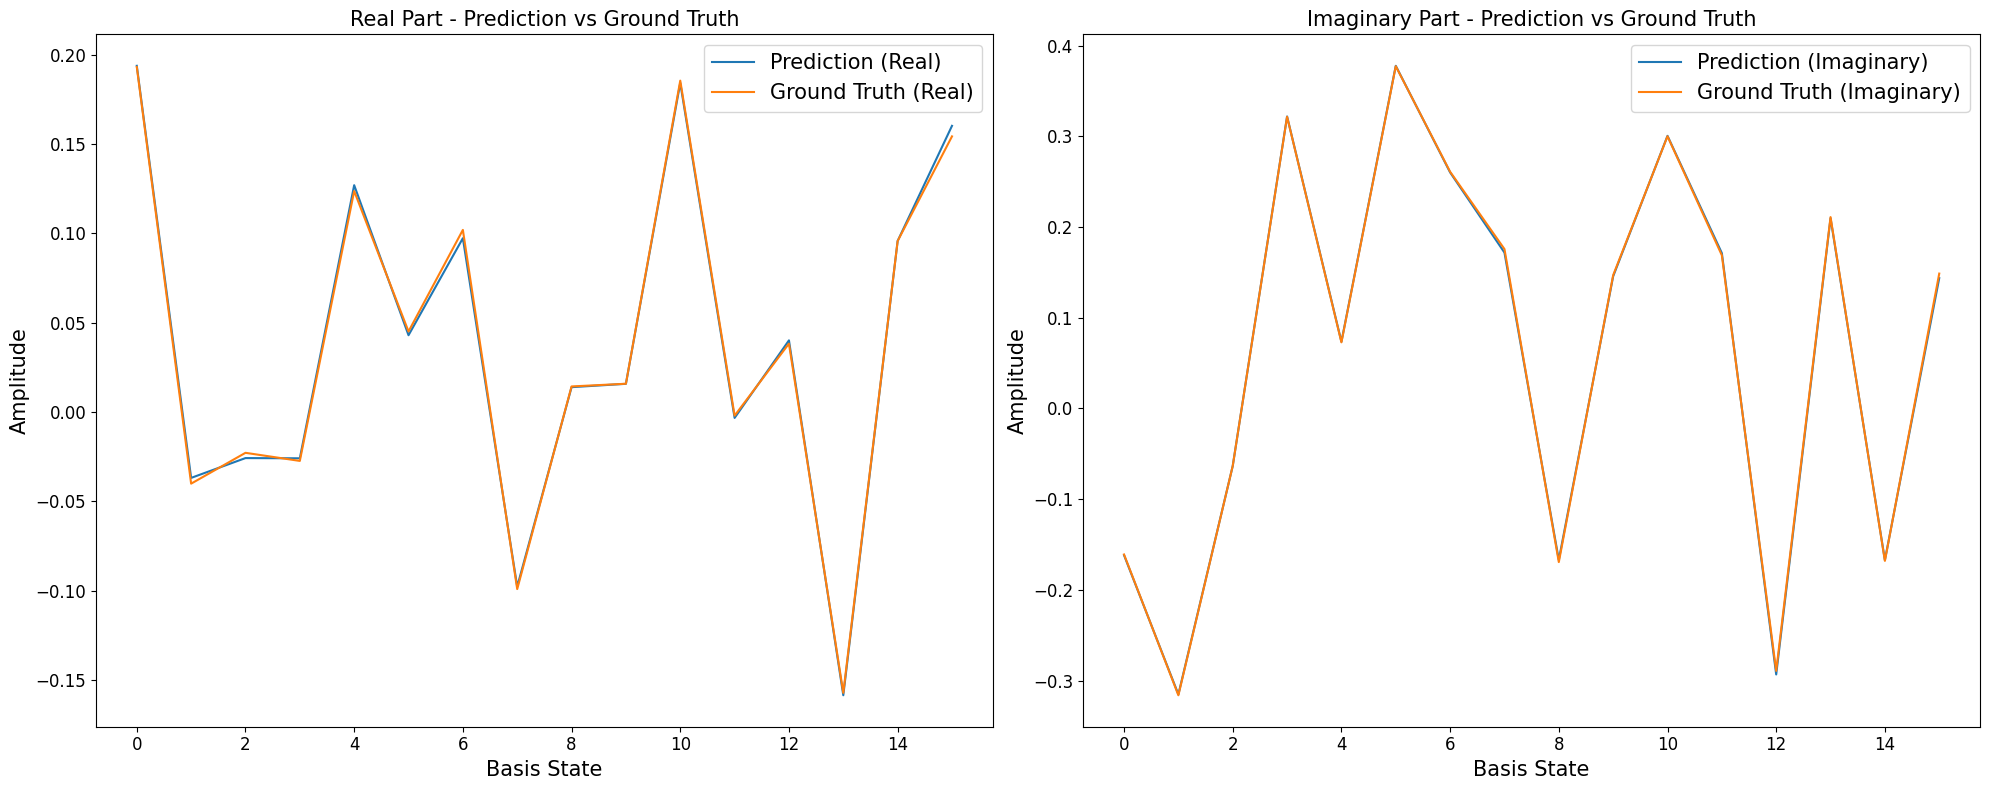

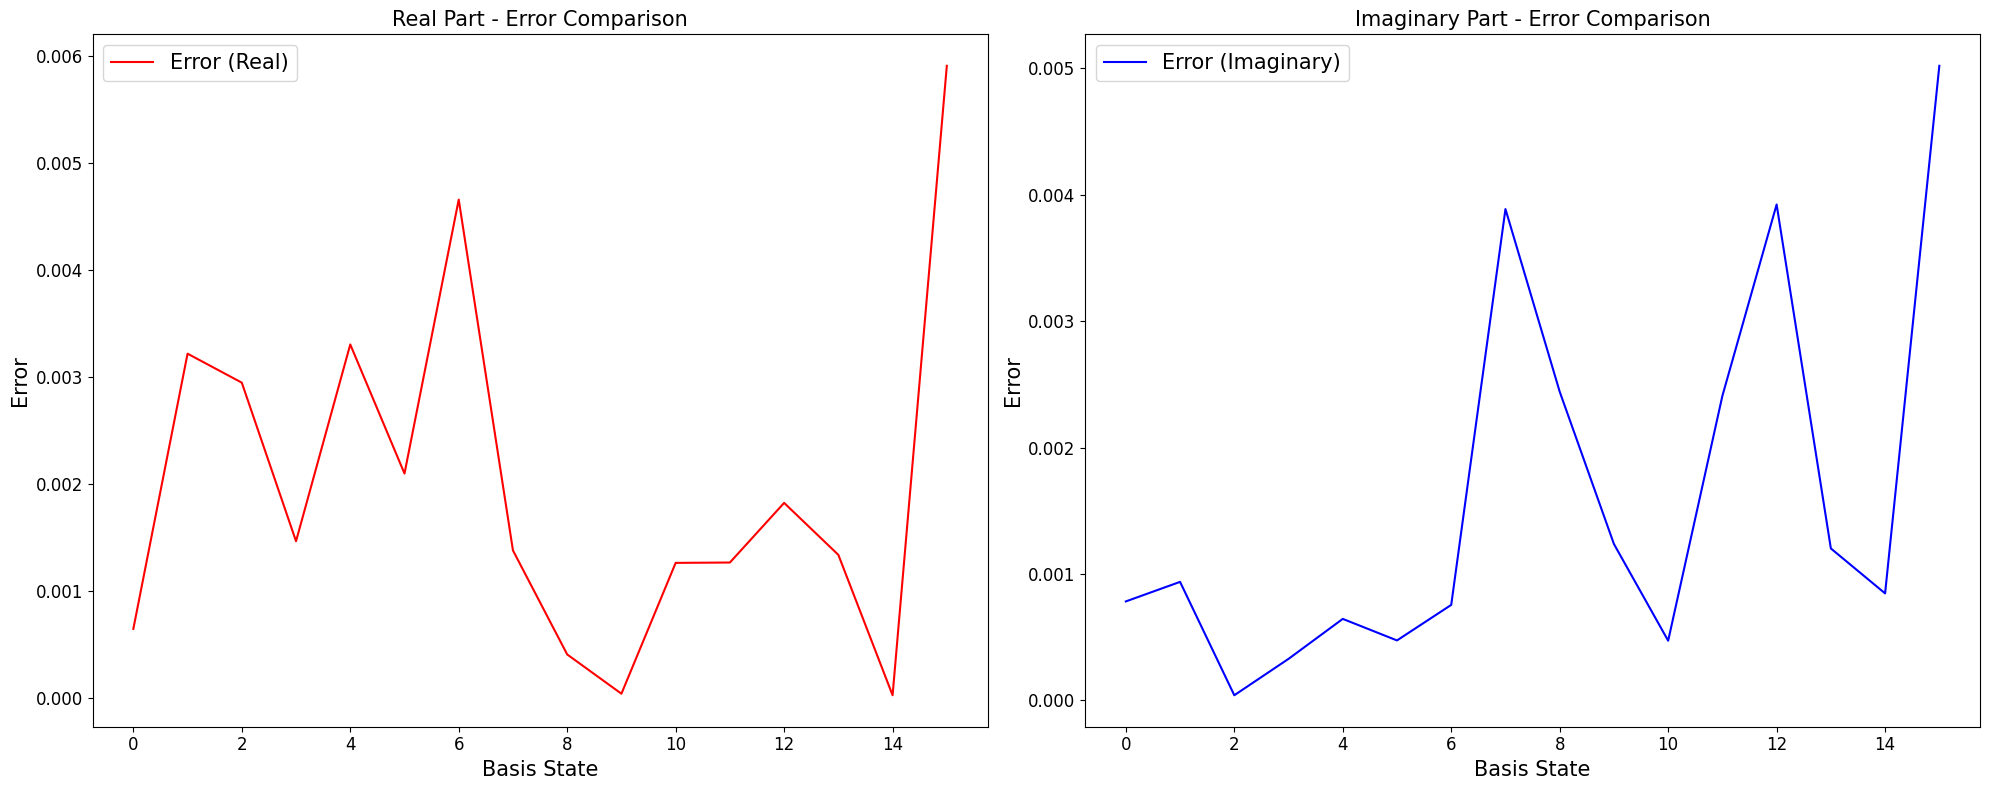

In [14]:
N = 4  # Number of particles
num_states = 1000  # Number of input states
train_ratio = 0.8  # Ratio of training to testing data
batch_size = 5


_, test_loader = create_dataset(N,num_states,train_ratio,batch_size,Jx=Jx,Jy=Jy,Jz=Jz,h=h)
# Assuming `test_loader` is already defined
# Iterate through the test dataset and perform inference
predictions_list = []
ground_truth_list = []
for batch in test_loader:
    x, y = batch['x'].cuda(), batch['y'].cuda()  # Move data to GPU if available
    with torch.no_grad():
        predictions = model(x)  # Perform inference without gradient computation
    predictions_list.append(predictions.squeeze().cpu().numpy())
    ground_truth_list.append(y.squeeze().cpu().numpy())

# Concatenate predictions and ground truth across batches
predictions = np.concatenate(predictions_list)
ground_truth = np.concatenate(ground_truth_list)

print(ground_truth.shape)
# Plot the comparison with error
plot_comparison_with_error(predictions[0], ground_truth[0])  # Plot for the first sample in the dataset


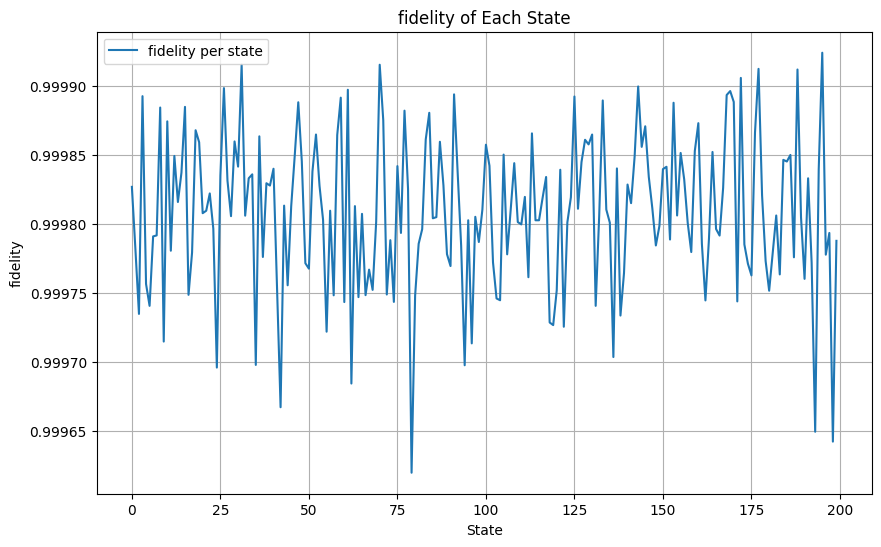

Mean fidelity is 0.999808620615415


In [15]:



fidelity_vec = []
for i in range(len(predictions)):  # Iterate over the length of predictions
    fid = fidelity_state(predictions[i], ground_truth[i])
    fidelity_vec.append(fid)


# Calculate total MSE
total_fidelity = np.mean(fidelity_vec) 

plt.figure(figsize=(10, 6))
plt.plot(fidelity_vec, label='fidelity per state')
plt.xlabel('State')
plt.ylabel('fidelity')
plt.title('fidelity of Each State')
plt.legend()
plt.grid(True)
plt.show()

print("Mean fidelity is", total_fidelity)


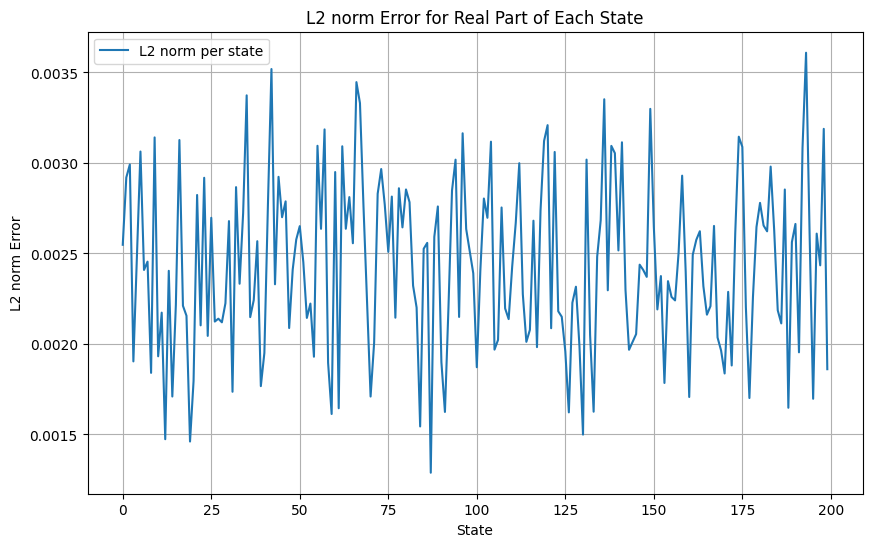

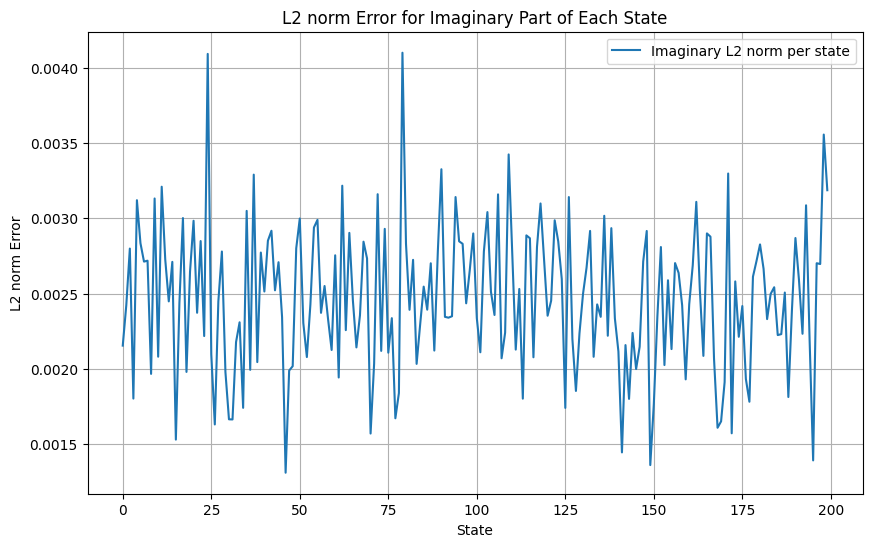

Total Mean Squared Error (Real): 6.142099e-06
Total Mean Squared Error (Imaginary): 6.2934555e-06
L2 norm (Real): 0.002478326
L2 norm (Imaginary): 0.0025086761


In [16]:
# Calculate MSE for each state
state_mse_real = []
state_mse_imag = []
for i in range(len(predictions)):  # Iterate over the length of predictions
    mse_real, mse_imag = calculate_mse(predictions[i], ground_truth[i])
    state_mse_real.append(mse_real)
    state_mse_imag.append(mse_imag)

# Calculate total MSE
total_mse_real = np.mean(state_mse_real) 
total_mse_imag = np.mean(state_mse_imag)

# Plot MSE for each state (real part)
plt.figure(figsize=(10, 6))
plt.plot(np.sqrt(state_mse_real), label='L2 norm per state')
plt.xlabel('State')
plt.ylabel('L2 norm Error')
plt.title('L2 norm Error for Real Part of Each State')
plt.legend()
plt.grid(True)
plt.show()

# Plot MSE for each state (imaginary part)
plt.figure(figsize=(10, 6))
plt.plot(np.sqrt(state_mse_imag), label='Imaginary L2 norm per state')
plt.xlabel('State')
plt.ylabel('L2 norm Error')
plt.title('L2 norm Error for Imaginary Part of Each State')
plt.legend()
plt.grid(True)
plt.show()

print("Total Mean Squared Error (Real):", total_mse_real)
print("Total Mean Squared Error (Imaginary):", total_mse_imag)
print("L2 norm (Real):", np.sqrt(total_mse_real))
print("L2 norm (Imaginary):", np.sqrt(total_mse_imag))

In [17]:
#{'test_loader_h1': 0.01946521393954754, 'test_loader_l2': 0.020400521710515023}
#Mean fidelity is 0.9996228222722542

## Autoregressive rollout

In [18]:

num_states = 1000  # Number of input states
train_ratio = 0.8  # Ratio of training to testing data
batch_size = 5

rollout_steps = 10  # Number of autoregressive rollout steps
input_states_wavefunction = generate_random_input_states_wavefunction(N, num_states)
print(input_states_wavefunction.shape)
spatial_grid = torch.linspace(0, 1, 2**N).unsqueeze(0).expand(batch_size, -1).cuda()

# Define evolution times
times =  3.14

hamiltonian= construct_hamiltonian(N,Jx,Jy,Jz,h)
index,_= ordered_indices(N,hamiltonian)
# Construct Hamiltonian
hamiltonian2= order_hamiltonian(hamiltonian,index)
_,test_loader=create_dataset(N,num_states,train_ratio,batch_size,Jx=Jx,Jy=Jy,Jz=Jz,h=h)
predictions, ground_truth = autoregressive_rollout(model,test_loader, rollout_steps,spatial_grid,hamiltonian2.cuda(),times)


torch.Size([1000, 16])
[Dataset] x_train: torch.Size([800, 2, 16]), y_train: torch.Size([800, 1, 16])
[Dataset] x_test: torch.Size([200, 2, 16]), y_test: torch.Size([200, 1, 16])


In [19]:
#flattening the tensor from eg: [10,200,16] to [2000,16]
predictions_final = predictions.view(-1, predictions.size(-1))
ground_truth_final=ground_truth.view(-1,ground_truth.size(-1))

# Convert to NumPy array
predictions_numpy = predictions_final.cpu().numpy()
ground_truth_numpy=ground_truth_final.cpu().numpy()
print(predictions_numpy.shape)
print(ground_truth_numpy.shape)

(2000, 16)
(2000, 16)


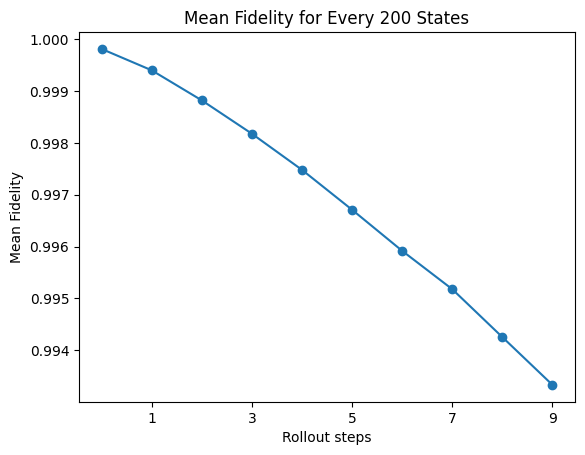

mean fidelity tt: 0.9998691124832391
std fidelity tt: 0.0
Total Mean Fidelity: 0.996906448004598
total std dev is: 0.003076159937552049


In [20]:
# Calculate fidelities for each pair of states
fidelities = []
test_states=num_states-int(num_states*train_ratio)
range_len= int(rollout_steps*(test_states))
for i in range(range_len):
    fid = fidelity_state(predictions_numpy[i], ground_truth_numpy[i])
    fidelities.append(fid)

# Calculate mean fidelity for every 200 states
mean_fidelities_len = []
std_fidelities_len=[]
for i in range(0, range_len, test_states):
    mean_fidelity = np.mean(fidelities[i:i+test_states])
    std_fidelity =np.std(fidelities[i:i+test_states])
    mean_fidelities_len.append(mean_fidelity)
    std_fidelities_len.append(std_fidelity)

# Calculate total mean fidelity
total_fidelity_tt=np.mean(fidelities[:1])
total_std_tt= np.std(fidelities[:1])
total_mean_fidelity = np.mean(fidelities[1:])
total_std_fidelity = np.std(fidelities[1:])

# Plot mean fidelity for every 200 states
plt.plot(mean_fidelities_len, marker='o')
plt.xlabel('Rollout steps')
plt.ylabel('Mean Fidelity')
plt.xticks([1,3,5,7,9]) #change this for different rollout steps
plt.title(f'Mean Fidelity for Every {test_states} States')
plt.show()

print("mean fidelity tt:", total_fidelity_tt)
print("std fidelity tt:", total_std_tt)
print("Total Mean Fidelity:", total_mean_fidelity)
print("total std dev is:", total_std_fidelity)